<a href="https://colab.research.google.com/github/LBncl/AmazonMLInterviewQuestion/blob/main/NAFLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAFLD PROJECT

## Imports

In [10]:
# Imports
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Cleaning

In [4]:
# Read in data
df = pd.read_excel('master_with_nordic_and_multiBM.xlsx')

# Check if dataFrame is empty
if df.empty:
    print('DataFrame is empty!')

In [6]:
# Subset data frame
main_df = df.filter(items=['CPH_EV_AGE_CALC', 'TBL.PATIENT.INFO..PI_BL_GENDER', 'CPH_EV_CI_BMI_CALC',
                         'TBL.ALL.EVENTS..AE_SF_ALCO_XS', 'insulin_resistance', 'hypertensive', 'waist_to_hip_ratio',
                         'idf_metabolic_syndrome', 'eGFR', 'dyslipidaemia', 'fibroscan_stiffness_reliable',
                         'TBL.ALL.EVENTS..AE_BR_ALT_iuL',
                         'TBL.ALL.EVENTS..AE_BR_AST_iuL', 'TBL.ALL.EVENTS..AE_BR_GGT_iuL',
                         'TBL.ALL.EVENTS..AE_BR_FERR_ugL',
                         'TBL.ALL.EVENTS..AE_BR_PLT_109L', 'TBL.ALL.EVENTS..AE_BR_CREAT_umolL_CALC',
                         'TBL.ALL.EVENTS..AE_BR_STG_mmolL_CALC',
                         'TBL.ALL.EVENTS..AE_BR_ALBU_gL_CALC', 'TBL.ALL.EVENTS..AE_BR_BILI_umolL_CALC',
                         'TBL.ALL.EVENTS..AE_BR_IGA',
                         'TBL.ALL.EVENTS..AE_CD_OSA', 'LIT_NB_CK18_M30', 'LIT_NB_CK18_M65', 'LIT_NB_PRO_C3', 'LIT_NB_PRO_C6',
                          'LIT_NB_ELF', 'FIB4', 'NFS', 'APRI', 'ADAPT', 'FIBC3', 'ABC3D', 'BARD', 'AST_ALT_Ratio', 'response_1', 'response_2', 'response_3a', 'response_3b', 
                             'response_4', 'response_5', 'response_6a', 'response_6b', 'response_7'])

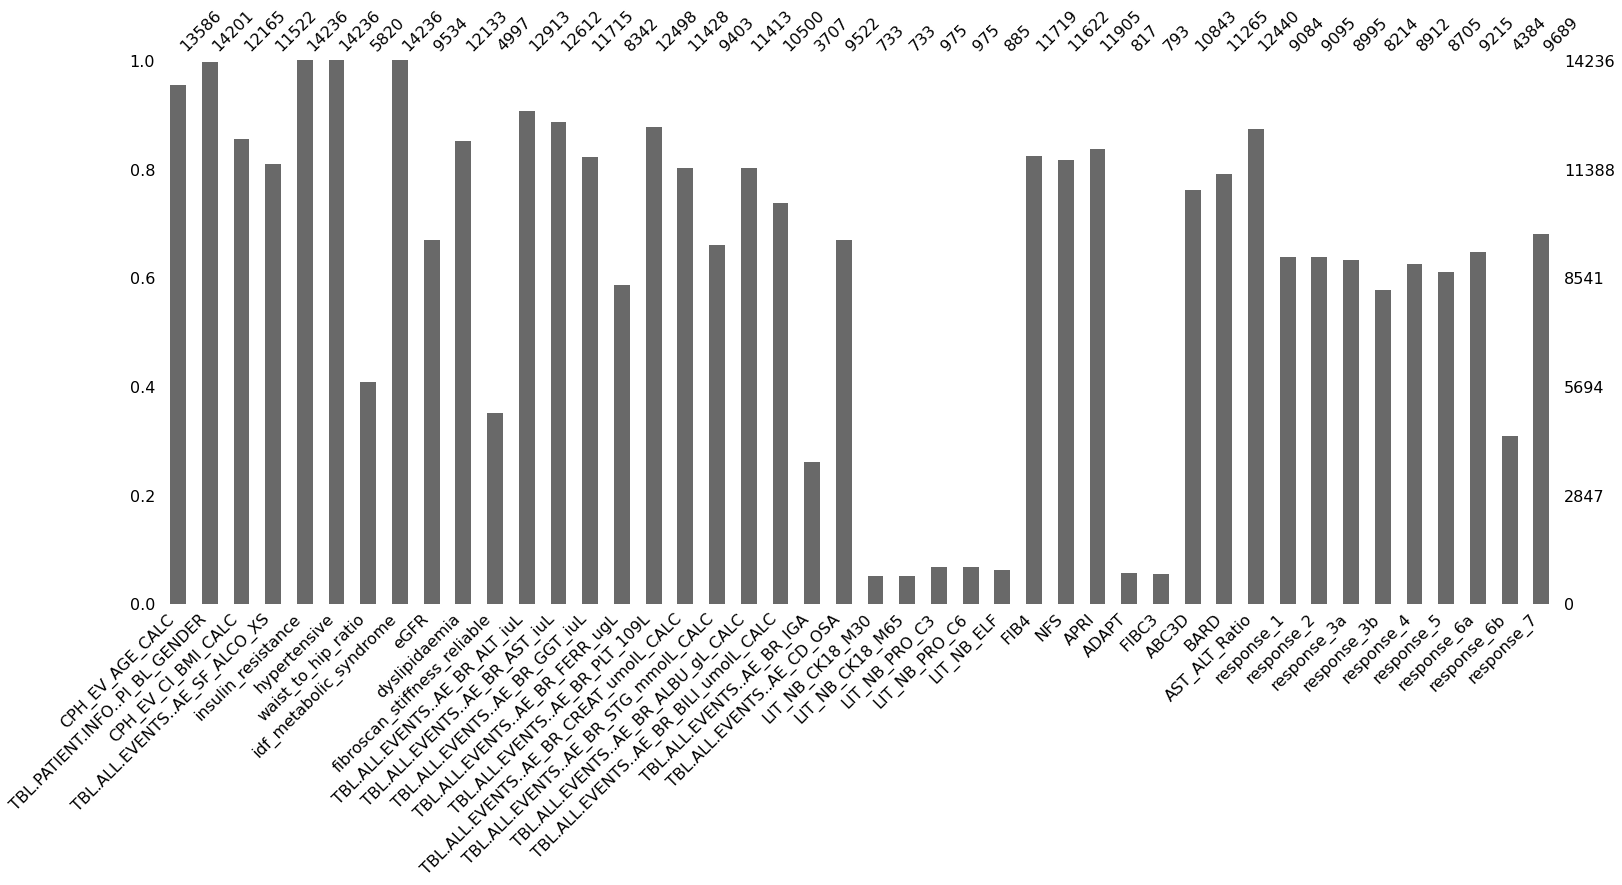

In [91]:
msno.bar(main_df)

In [25]:
from sklearn import preprocessing

# Convert required variables to boolean and normlaise the remaining variables
features = main_df.iloc[:, 0:35]
features.iloc[:, [1,3,4,5,7,9,21]] = features.iloc[:, [1,3,4,5,7,9,21]].astype(bool)
cols_normalise = features.select_dtypes(include=[np.float64])
features[cols_normalise.columns] = preprocessing.scale(cols_normalise)

## Data Imputation Strategies

In [26]:
# Imports for imputation functions
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression

In [27]:
# Single imputation with mean to replace not a number (NaNs)
def nan2mean(fdf):
    cols = list(fdf.columns)
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [28]:
# Single imputation with median to replace not a number (NaNs)
def nan2median(fdf):
    cols = list(fdf.columns)
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [29]:
# Single imputation with most_frequent to replace not a number (NaNs)
def nan2most_frequent(fdf):
    cols = list(fdf.columns)
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [37]:
# Multiple Imputation by chained equation linear regression
def nan2mice(fdf):
    cols = list(fdf.columns)
    lr = LinearRegression()
    imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, imputation_order='roman',random_state=0)
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [38]:
# Imputation by K neasrest neighbours
def nan2knn(fdf):
    cols = list(fdf.columns)
    imp = KNNImputer(n_neighbors=2, weights="distance")
    fdf=imp.fit_transform(fdf)
    fdf = pd.DataFrame(fdf, columns=cols)
    return fdf

In [42]:
featuresKNN = nan2knn(features)

In [44]:
# function to compare the denisty of raw vs imputed data
def compare_denisty(column_name, fdf):
    d = {'raw': preprocessing.scale(df[column_name]), 'imputed': fdf[column_name]}
    fdata = pd.DataFrame(data=d)
    # calling density() to make multiple density plot 
    fdata.plot.density(figsize = (7, 7),linewidth = 2)
    plt.xlabel(column_name)
    return fdata

,raw,imputed
0,1.625120,1.625120
1,2.329863,2.329863
2,2.829475,2.829475
3,NaN,1.444007
4,NaN,-0.214810
...,...,...
14231,NaN,-0.057859
14232,NaN,0.117089
14233,4.608980,4.608980
14234,NaN,0.625546


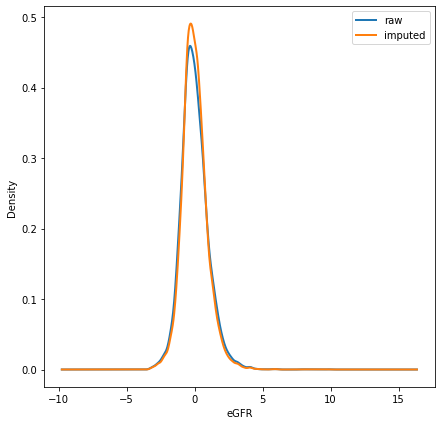

In [45]:
compare_denisty("eGFR",featuresKNN)

## Model evaluation

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Logistic Regression model
def model_logREG(fdf, response):
  # Pull the correct resposne variable from the dataframe
  y = df[response]
  # Remove all rows with missing observations
  X = fdf
  X['y'] = y
  X = fdf.dropna()
  # Split data into test and trian
  X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 0:35], X.iloc[: , -1], test_size=0.20, random_state=0)
  # Implement the model
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print(classification_report(y_test, y_pred))
  return y_pred

In [122]:
logKnn = model_logREG(featuresKNN, 'response_5')

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       765
         1.0       0.68      0.69      0.68       976

    accuracy                           0.64      1741
   macro avg       0.64      0.63      0.64      1741
weighted avg       0.64      0.64      0.64      1741



In [124]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# SVM model
def model_SVM(fdf, response):
  # Pull the correct resposne variable from the dataframe
  y = df[response].dropna()
  # Remove all rows with missing observations
  X = fdf
  X['y'] = y
  X = fdf.dropna()
  # Split data into test and trian
  X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 0:35], X.iloc[: , -1],test_size=0.20, random_state=0)
  # Implement the model
  clf = svm.SVC(kernel='linear')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  return y_pred

In [125]:
SVM = model_SVM(featuresKNN, 'response_1')

              precision    recall  f1-score   support

         0.0       0.57      0.35      0.43       718
         1.0       0.66      0.83      0.73      1099

    accuracy                           0.64      1817
   macro avg       0.61      0.59      0.58      1817
weighted avg       0.62      0.64      0.62      1817



In [129]:
import xgboost as xgb

def model_XGB(fdf, response):
  # Pull the correct resposne variable from the dataframe
  y = df[response]
  # Remove all rows with missing observations
  X = fdf
  X['y'] = y
  X = fdf.dropna()
  # Split data into test and trian
  X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 0:35], X.iloc[: , -1], test_size=0.20, random_state=0)
  # Implement the model
  xgb_cl = xgb.XGBClassifier()
  xgb_cl.fit(X_train, y_train)
  y_pred = xgb_cl.predict(X_test)
  print(classification_report(y_test, y_pred))
  return y_pred


In [130]:
XGB = model_XGB(featuresKNN, 'response_1')

              precision    recall  f1-score   support

         0.0       0.59      0.43      0.50       718
         1.0       0.68      0.81      0.74      1099

    accuracy                           0.66      1817
   macro avg       0.64      0.62      0.62      1817
weighted avg       0.65      0.66      0.64      1817

